## makemore: becoming a backprop ninja

In [1]:
# there no change change in the first several cells from last lecture

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# ok biolerplate done, now we get to the action:

In [8]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [11]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3322, grad_fn=<NegBackward0>)

In [12]:
# dbnvar = (-0.5) * (bnvar+1e-5) ** (-1.5)

In [13]:
# bndiff2.shape,bnvar.shape,hprebn.shape

In [14]:
# dbndiff2 = (1/(n-1)) * torch.ones_like(hprebn) * dbnvar
# dbndiff2.shape
bnmeani.shape,hprebn.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [15]:
# logprobs.shape
# logprobs[range(32),Yb]
# probs.shape
# (counts.shape,counts_sum_inv.shape)

# counts_sum.shape
# counts.shape,counts_sum_inv.shape
# dnorm_logits[0,:]
# dlogit_maxes[0]
# -dnorm_logits[0,:]
# logits
# dlogits.sum(0).shape
# bnmeani.shape,dbndiff.shape
# hprebn.shape,dbnmeani.shape
# dhprebn += (1.0/(n-1))*torch.ones_like(hprebn) * dbnmeani 
# dhprebn.shape
# hprebn.shape
# (torch.ones_like(hprebn) * dbnmeani).shape

In [16]:
# torch.ones(2,3) - torch.arange(2,5)
# logits[0,:]
# h.shape,h.T.shape,dlogits.shape,W2.shape,b2.shape
# dhpreact.dtype
# hpreact.loss().dtype()


In [17]:
# dnorm_logits[0,:]
# logits.max(1)
# logits.shape
# plt.imshow(F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]))
# plt.show()
# bngain.shape,bnraw.shape,dhpreact.shape
# bnraw[0,:]
# bngain[0,:]
# dbngain = (bnraw * dhpreact)
# dbngain.shape,bngain.shape
# bnbias.shape,dhpreact.shape
# bnraw.shape,dhpreact.shape,bngain.shape
# dbnraw =  (bngain * dhpreact).sum(axis=0,keepdim=True)
# dbnraw.shape
# (bndiff * dbnraw).shape

# dbnmeani.shape,bnmeani.shape
# emb.shape,embcat.shape
# C.shape,demb.shape,Xb.shape
# demb[10].shape

In [18]:
# demb[0,0].shape

In [19]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# Your code here!
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1/n

dprobs = (1/probs) * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(axis=1,keepdim=True)

dcounts = counts_sum_inv * dprobs

dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv

dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = norm_logits.exp() * dcounts

dlogits = dnorm_logits.clone()

dlogit_maxes = -dnorm_logits.sum(axis=1,keepdim=True)

dlogits += (F.one_hot(logits.max(1).indices,num_classes=logits.shape[1])) * dlogit_maxes
 
dh = dlogits @ W2.T

dW2 = h.T @ dlogits

db2 = dlogits.sum(0)

dhpreact = (1.0 - h**2) * dh # nearly close its okay

dbngain = (bnraw * dhpreact).sum(axis=0,keepdim=True) #nearly close its okay

dbnbias = (dhpreact).sum(axis=0,keepdim=True) 

dbnraw =  (bngain * dhpreact)

dbnvar_inv = (bndiff * dbnraw).sum(axis=0,keepdim=True)

dbndiff = (bnvar_inv * dbnraw)

dbnvar = (-0.5) * (bnvar+1e-5) ** (-1.5) * dbnvar_inv

dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dbnvar

dbndiff += 2* bndiff * dbndiff2

dhprebn = dbndiff.clone()

dbnmeani = -1 * dbndiff.sum(axis=0,keepdim=True)

dhprebn += (1.0/n)* (torch.ones_like(hprebn) * dbnmeani) 
 
#linear layer
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(axis=0,keepdim=True)

# demb = dembcat.reshape(n,emb.shape[1],n_embd) # or
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i,j]
        dC[ix] += demb[i,j] 


# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [20]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.332185745239258 diff: 0.0


In [21]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits,1)# TODO. my solution is 3 lines
dlogits[range(n),Yb] -= 1
dlogits /= n #mean
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09


In [22]:
logits[0,:]

tensor([ 0.8109,  1.0608, -0.4967,  0.4572, -0.4532,  0.8960, -0.2760,  0.0366,
        -0.5597,  0.0119,  0.2282,  0.1142,  0.1810, -0.0776,  0.1183, -0.7748,
        -1.2324, -0.5125, -0.6309,  0.5240,  0.4965, -0.3088, -0.2428,  0.8108,
         0.6239, -0.2069, -0.4542], grad_fn=<SliceBackward0>)

In [23]:
dlogits[0,:] 

tensor([ 0.0022,  0.0028,  0.0006,  0.0016,  0.0006,  0.0024,  0.0007,  0.0010,
        -0.0307,  0.0010,  0.0012,  0.0011,  0.0012,  0.0009,  0.0011,  0.0005,
         0.0003,  0.0006,  0.0005,  0.0017,  0.0016,  0.0007,  0.0008,  0.0022,
         0.0018,  0.0008,  0.0006], grad_fn=<SliceBackward0>)

In [24]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [25]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
# TODO. my solution is 1 (long) line
dhprebn = bngain*bnvar_inv/n * (n*dhpreact- dhpreact.sum(0)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)) 
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [42]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):
      # minibatch construct
      ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
      Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

      # forward pass
      emb = C[Xb] # embed the characters into vectors
      embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
      # Linear layer
      hprebn = embcat @ W1 + b1 # hidden layer pre-activation
      # BatchNorm layer
      # -------------------------------------------------------------
      bnmean = hprebn.mean(0, keepdim=True)
      bnvar = hprebn.var(0, keepdim=True, unbiased=True)
      bnvar_inv = (bnvar + 1e-5)**-0.5
      bnraw = (hprebn - bnmean) * bnvar_inv
      hpreact = bngain * bnraw + bnbias
      # -------------------------------------------------------------
      # Non-linearity
      h = torch.tanh(hpreact) # hidden layer
      logits = h @ W2 + b2 # output layer
      loss = F.cross_entropy(logits, Yb) # loss function

      # backward pass
      for p in parameters:
        p.grad = None
    #   loss.backward() # use this for correctness comparisons, delete it later!

      # manual backprop! #swole_doge_meme
      # -----------------
      # YOUR CODE HERE :)
      dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None

      dlogits = F.softmax(logits,1)
      dlogits[range(n),Yb] -= 1
      dlogits /= n 

      #2nd layer
      dh = dlogits @ W2.T
      dW2 = h.T @ dlogits
      db2 = dlogits.sum(0)

      #tanh 
      dhpreact = (1.0 - h**2) * dh # nearly close its okay

      #batch norm backprop
      dbngain = (bnraw * dhpreact).sum(axis=0,keepdim=True) #nearly close its okay
      dbnbias = (dhpreact).sum(axis=0,keepdim=True) 
      dhprebn = bngain*bnvar_inv/n * (n*dhpreact- dhpreact.sum(0)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)) 

      #1st layer
      dembcat = dhprebn @ W1.T
      dW1 = embcat.T @ dhprebn
      db1 = dhprebn.sum(axis=0,keepdim=True)

      #embedding
      demb = dembcat.view(emb.shape)
      dC = torch.zeros_like(C)
      for j in range(Xb.shape[0]):
          for k in range(Xb.shape[1]):
              ix = Xb[j,k]
              dC[ix] += demb[j,k] 


      grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
      # -----------------

      # update
      lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
      for p, grad in zip(parameters, grads):
    #     p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
        p.data += -lr * grad.view(p.data.shape) # new way of swole doge TODO: enable

      # track stats
      if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
      lossi.append(loss.log10().item())
        
    #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #     break

12297
      0/ 200000: 3.7847
  10000/ 200000: 2.1599
  20000/ 200000: 2.3687
  30000/ 200000: 2.4460
  40000/ 200000: 1.9369
  50000/ 200000: 2.3589
  60000/ 200000: 2.3971
  70000/ 200000: 2.0741
  80000/ 200000: 2.3603
  90000/ 200000: 2.0951
 100000/ 200000: 1.9592
 110000/ 200000: 2.3199
 120000/ 200000: 1.9622
 130000/ 200000: 2.3883
 140000/ 200000: 2.2947
 150000/ 200000: 2.1845
 160000/ 200000: 1.8540
 170000/ 200000: 1.8190
 180000/ 200000: 2.0064
 190000/ 200000: 1.8815


In [41]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.6763806343078613e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


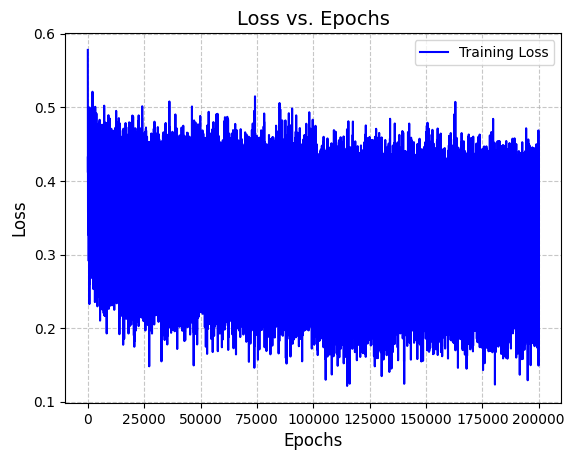

In [64]:
epoch_list = torch.arange(0,max_steps).tolist()
plt.plot(epoch_list,lossi, label='Training Loss', color='blue')

# Add labels and title
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs. Epochs', fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()

In [43]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [44]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070484161376953
val 2.108945369720459


In [45]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [46]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
reisha.
endraege.
dered.
elin.
shy.
jen.
edelisson.
arleigh.
malaia.
noshubergihira.
stin.
joselle.
joseus.
kubenteda.
jamyle.
